In [8]:
from graphviz import Digraph
import pyreadstat
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
import logging
import unittest
import ananke
from ananke.graphs import ADMG, DAG
from collections.abc import Callable

In [4]:
vertices = set()
edges = []

# Quick parser to get vertices and edges
with open("pytetrad/PROJECT_learned_edges.txt") as f:
    lines = f.readlines()
    for line in lines[4:91]:
        split = line.split()
        # Skip undirected edges (Only undirected edges age --- gender)
        if split[2] == "---":
            continue
        vertices.add(split[1])
        vertices.add(split[3])
        edges.append((split[1], split[3]))

dag = DAG(list(vertices), edges)

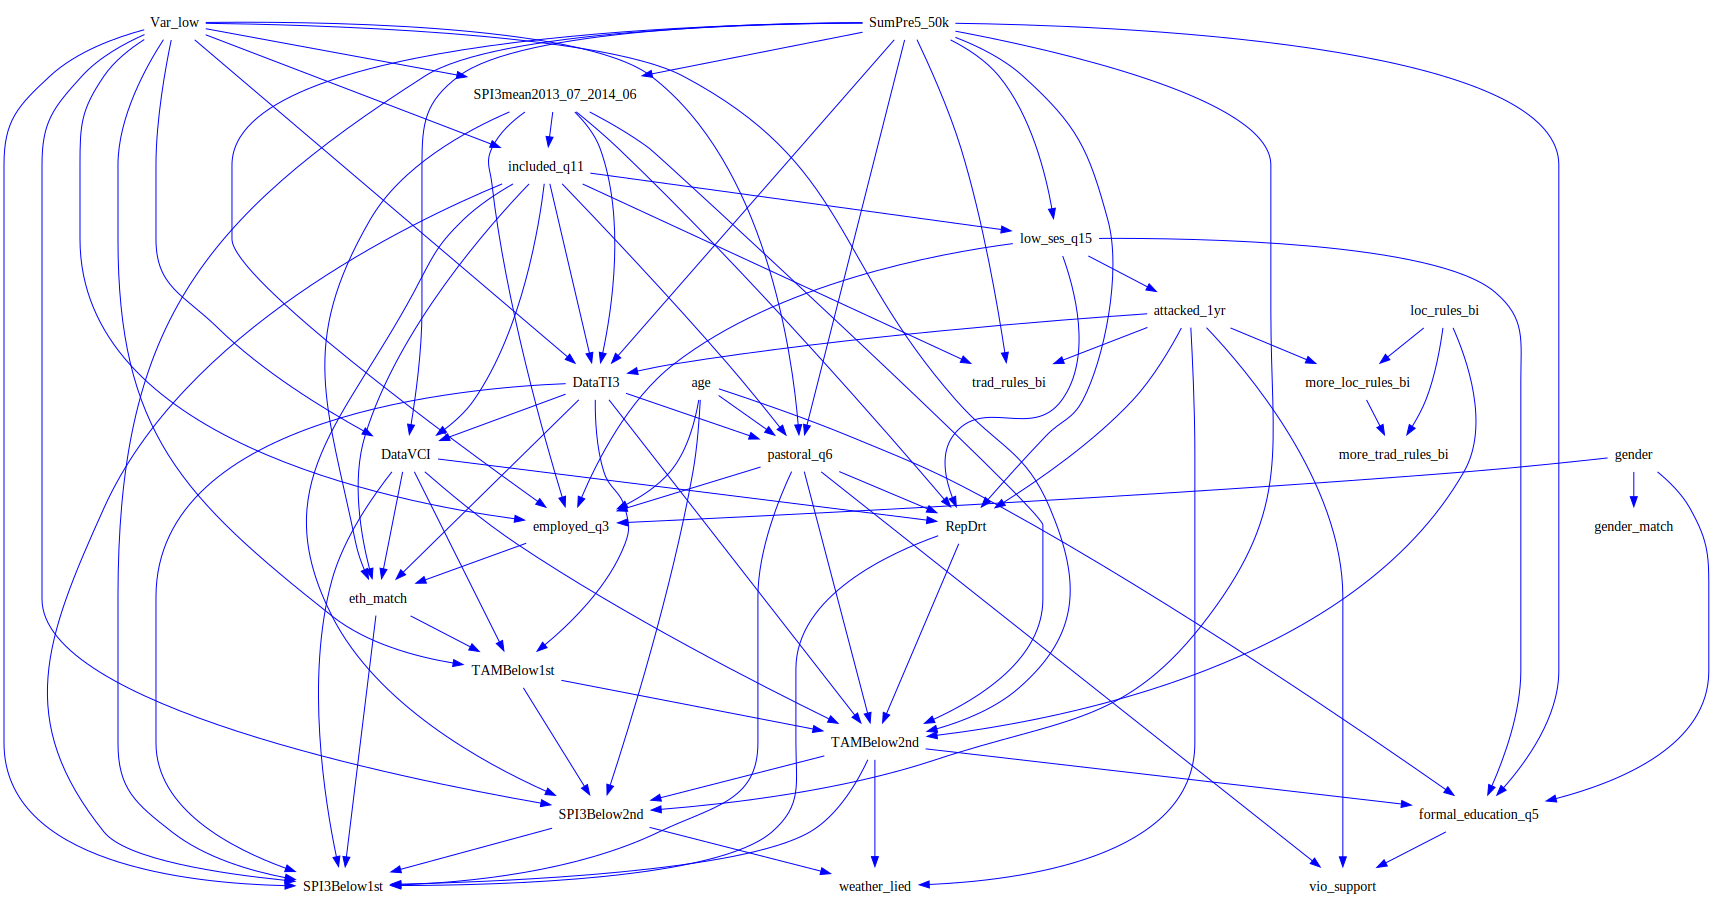

In [5]:
image = dag.draw()  # DAG.png
image

In [4]:
# From Ananke docs:
# https://ananke.readthedocs.io/en/latest/_modules/ananke/identification/opt_adjust.html
def get_opt_set(G, vertex1, vertex2):
    """
    function to get the optimal set from two vertices

    :param G: the graph
    :param vertex1: inference from vertex1, say treatment
    :param vertex2: inference to vertex2, say outcome

    """

    causal_nodes = [
        item for item in G.descendants([vertex1]) if item in G.ancestors([vertex2])
    ]
    if len(causal_nodes) == 0:
        print("No causal node!")
        return None
    causal_nodes.remove(vertex1)
    forb_set = [item for item in G.descendants(causal_nodes)]
    forb_set = forb_set + [
        vertex1
    ]  # The forbidden set characterizes those covariates that may never be included into a valid adjustment set

    opt_set = [item for item in G.parents(causal_nodes) if item not in forb_set]
    return set(opt_set)


def get_min_set(G, input, vertex1, vertex2):
    """
    function for minimal set

    :param G: DAG
    :param input: optimal set found using get_opt_set function
    :param vertex1: inference from vertex1, say treatment
    :param vertex2: inference to vertex2, say outcome

    """

    if len(input) == 0:
        logger.info("Adjustment set is empty!")
        return

    input_set = [item for item in input]

    is_minimal_set = 0  # flag for the minimal set

    # ABEL_ANGUS: create copy of G first to avoid destroying original
    G = G.copy()
    for element in G.children(
        [vertex1]
    ):  # prepare for d-separation test, construct a SWIG
        G.delete_diedge(vertex1, element)

    for element in input_set:
        new_set = [item for item in input_set if item not in element]
        is_d_separated = G.d_separated(
            vertex1, vertex2, new_set
        )  # check if d-separated
        if is_d_separated:
            is_minimal_set = 1
            final_set = get_min_set(G, new_set, vertex1, vertex2)

    if not is_minimal_set:
        # input set is minimal set
        return set(input_set)

    return set(final_set)

In [5]:
adjustment_set = get_opt_set(dag, "DataTI3", "vio_support")
# Prune
adjustment_set = get_min_set(dag, adjustment_set, "DataTI3", "vio_support")
adjustment_set = list(adjustment_set)

print(adjustment_set)

['SumPre5_50k', 'attacked_1yr', 'included_q11', 'SPI3mean2013_07_2014_06', 'Var_low']


In [6]:
SEED = 379


def frontdoor_ipw(
    data: pd.DataFrame, a_name: str, y_name: str, m_name: str, c_names: list[str]
) -> float:
    """
    Perform front door adjustment for a given treatment A and outcome Y using
    the mediator M and the covariates in C
    """

    # make a regression formula for M ~ A + C
    c_names = ["1"] + c_names
    c_formula = " + ".join(c_names)
    regression_formula = f"{m_name} ~ {a_name} + {c_formula}"

    # fit a logistic regression for M
    model = smf.glm(
        formula=regression_formula, family=sm.families.Binomial(), data=data
    ).fit()

    def p_m_given_a(data):
        M = data[m_name]
        p_M1 = model.predict(data)
        return M * p_M1 + (1 - M) * (1 - p_M1)

    # make interventional datasets
    data_a1 = data.copy()
    data_a0 = data.copy()
    data_a1[a_name] = 1
    data_a0[a_name] = 0

    # do the frontdoor computations
    result = np.mean(
        (p_m_given_a(data_a1) / p_m_given_a(data)) * data[y_name]
    ) - np.mean((p_m_given_a(data_a0) / p_m_given_a(data)) * data[y_name])
    return round(result, 3)


def compute_confidence_intervals(
    data: pd.DataFrame,
    estimator: Callable,
    num_bootstraps: int = 200,
    alpha: float = 0.05,
    **kwargs,
) -> tuple[float, float]:
    """
    Compute confidence intervals for a given estimator via bootstrap

    Returns tuple (q_low, q_up) for the lower and upper quantiles of the confidence interval.
    """

    Ql = alpha / 2
    Qu = 1 - alpha / 2
    estimates = []

    for i in range(num_bootstraps):

        # resample the data with replacement
        data_sampled = data.sample(len(data), replace=True, random_state=SEED)
        data_sampled.reset_index(drop=True, inplace=True)

        # add estimate from resampled data
        estimates.append(estimator(data_sampled, **kwargs))

    # calculate the quantiles
    quantiles = np.quantile(estimates, q=[Ql, Qu])
    q_low = quantiles[0]
    q_up = quantiles[1]
    return round(q_low, 3), round(q_up, 3)

In [10]:
# data = pd.read_csv("pytetrad/PROJECT_data.csv")
df, meta = pyreadstat.read_dta("replication_files_linke/DataJCRJune12.dta")

# causal_effect = compute_confidence_intervals(
#     data,
#     frontdoor_ipw,
#     a_name="DataTI3",
#     y_name="vio_support",
#     m_name="pastoral_q6",
#     c_names=adjustment_set,
# )
# print(effect)

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1341    0.0
1342    0.0
1343    0.0
1344    0.0
1345    0.0
Name: pastoral_q6, Length: 1346, dtype: float64
